# Minilab 8 - Predictions and _confidence intervals_

## SF Taxi data
We have already looked at how to predict taxi fares as a function of trip distance using [linear regression](https://en.wikipedia.org/wiki/Linear_regression). Now we will look at how confident we are in the linear regression model. Rather than constructing a single best-fit line for our taxi-data sample, we will construct a confidence interval for the linear regression.

As a reminder, the dataset is San Francisco Taxi data from 9/1/2012 to 9/17/2012. The dataset consists of 50,000 taxi trips taken in the Bay Area during that time period. For each trip we are given the departure time, arrival time, passenger fare, departure lat/lon coordinates, arrival lat/lon coordinates, departure taz and arrival taz. 

In [1]:
from datascience import *
import datetime
import matplotlib.pyplot as plt
import numpy as np
import warnings
from scipy import stats

warnings.filterwarnings("ignore")
%matplotlib inline

# Part 1: Recap of SF Taxi data 

In [2]:
sf_taxi = Table.read_table('data/SF_taxi_data.csv')
sf_taxi

id,departure time,arrival time,fare ($),num,dep lon,dep lat,arr lon,arr lat,deptaz,arrtaz,dist (miles)
0,9/1/12 0:11,9/1/12 0:20,13.2,1,-122.414,37.8027,-122.421,37.7854,38,30,1.98084
1,9/1/12 0:23,9/1/12 0:31,10.65,1,-122.42,37.7861,-122.435,37.7622,30,94,2.40224
2,9/1/12 0:45,9/1/12 0:49,9,1,-122.415,37.7747,-122.408,37.7826,10,11,0.479348
3,9/1/12 0:41,9/1/12 0:54,13.95,2,-122.419,37.8066,-122.415,37.7781,40,10,2.12241
4,9/1/12 1:09,9/1/12 1:13,7.35,1,-122.43,37.7978,-122.418,37.789,45,32,1.03807
5,9/1/12 1:40,9/1/12 1:52,11.75,1,-122.433,37.7841,-122.411,37.787,77,7,0.960851
6,9/1/12 2:49,9/1/12 2:51,5.15,1,-122.409,37.7856,-122.412,37.791,7,29,0.414315
7,9/1/12 3:29,9/1/12 3:47,43.65,1,-122.403,37.7927,-122.386,37.6181,2,239,14.5105
8,9/1/12 0:33,9/1/12 0:57,46.75,1,-122.387,37.6174,-122.407,37.7889,239,5,14.2747
9,9/1/12 4:39,9/1/12 4:43,6.25,1,-122.422,37.7977,-122.418,37.789,34,31,0.685312


### Adding input variables
As we did in minilab 7, we can use helper functions to create other input varaibles.

In [3]:
#Helper methods
def get_dur(start,finish): 
    start_time = datetime.datetime.strptime(start, "%m/%d/%y %H:%M")
    end_time = datetime.datetime.strptime(finish, "%m/%d/%y %H:%M")
    return (end_time-start_time).seconds/60.

def get_hour(s): 
    return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").hour

def get_date(s): 
    return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").date()

def get_weekday(s): # 0 = Monday - 6= Sunday
    return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").date().weekday()

def base_fare(d):
    # 3.5 + 0.55*(5*d - 1), considering only completed 1/5-th miles (hence np.modf()[1])
    return ( 3.5 + 0.55* (np.modf(5*d)[1] - 1) )

def fit(x,y): return np.poly1d(np.polyfit(x,y,1))(x)

In [4]:
#Adding other inputs to our data table
sf_taxi["duration (min)"] = sf_taxi.apply(lambda start, finish: get_dur(start, finish), 
                                          ["departure time", "arrival time"])
sf_taxi['start hour'] = sf_taxi.apply(get_hour, "departure time")
sf_taxi['date'] = sf_taxi.apply(get_date, "departure time")
sf_taxi['day of week'] = sf_taxi.apply(get_weekday, "departure time")
sf_taxi['extra'] = sf_taxi["fare ($)"] - base_fare(sf_taxi["dist (miles)"])
#reminder extra is fare (beyond expected distance fair) paid by a passenger.

### Filter sf taxi data
As we did in minilab 7 we are only going to focus on data where the number of passengers = 1, where the base fare is greater than 3.5, and where the extra fee is non-negative. We will also focus on trips that are non-SFO trips and have a distance between 0.1 and 15 miles. 

In [5]:
#Filter erroneous trips
# one pax trips only
sf_taxi = sf_taxi.where(sf_taxi["num"]==1)
# fares <3.5 are likely to be errors
sf_taxi = sf_taxi.where(sf_taxi["fare ($)"]>3.5)
# filter table to only contain fares where extra>0, assume extra<0 are erroneous.
sf_taxi = sf_taxi.where(sf_taxi["extra"]>=0)

#filter non-SFO trips with 0.1 miles < distance < 15 miles.
nsfo_taxi = sf_taxi.where( (sf_taxi["deptaz"] != 239) & (sf_taxi["arrtaz"] != 239) )
# Keep only trips shorter than 15 miles, and longer than 0.1
nsfo_taxi = nsfo_taxi.where(nsfo_taxi["dist (miles)"] < 15)
nsfo_taxi = nsfo_taxi.where(nsfo_taxi["dist (miles)"] > 0.1)

## Visualize fares data
As we did in minilab7 we can visualize fare vs. trip distance in a scatter plot. We can also visualize extra fare vs. distance. 
### Fare vs Trip Length:

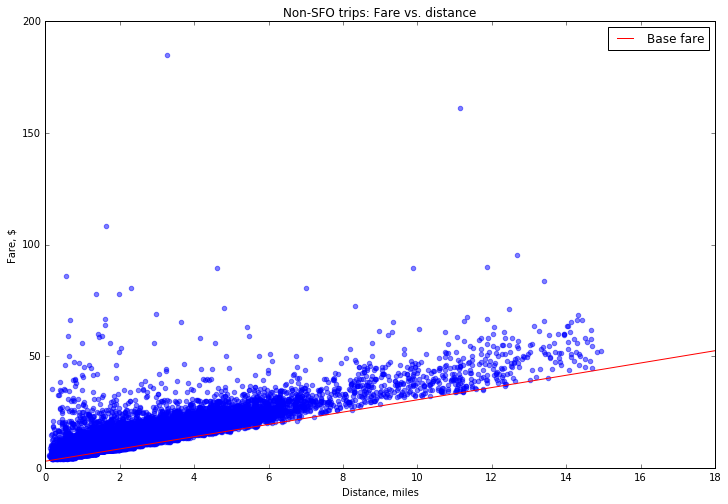

In [6]:
plt.figure(figsize = (12,8))

# plot fares for all trips
x, y=  nsfo_taxi.column("dist (miles)"), nsfo_taxi.column("fare ($)")
plt.scatter(x,y,color='blue', alpha = .5)

# plot the lower bound of the fare, i.e. the official formula
plt.plot([0, 40], [base_fare(0), base_fare(40)], 'red', label='Base fare')

plt.title('Non-SFO trips: Fare vs. distance')
plt.xlabel('Distance, miles')
plt.ylabel('Fare, $')
plt.ylim([0,200])
plt.xlim([0,18])
plt.legend()

### Extra Fare vs Trip Length:

(0, 10)

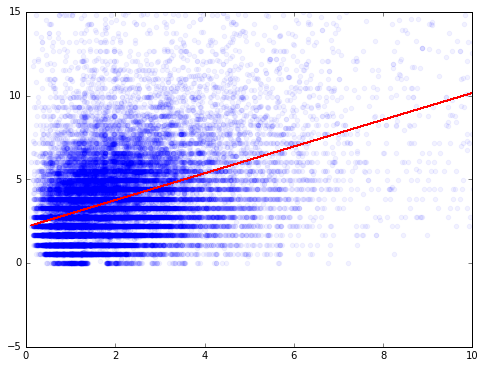

In [7]:
x, extra = nsfo_taxi.column("dist (miles)"), nsfo_taxi.column("extra")
#distance vs. extra
plt.figure(figsize = (8,6))
plt.scatter(x, extra, color='blue', alpha = .05, label='Delay surcharge')

plt.plot(x, fit(x,extra), color='red')
plt.ylim([-5,15])
plt.xlim([0,10])

# Part 2.  Prediction with linear regression

The function below applies slope and intercept computations and returns these parameters of a simple linear regression y=a*x+b fit to data in a given table. 

In [8]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    "Compute r."
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def linear_coeff(table, x, y):
    """Return the regression line slope and intercept coefficients."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a, b

## Predictive model

Our predictive models will be using the extra fare computed with an SFMTA formula, and fitting a linear regression to the remaining extra fare. 

In [9]:
def predict_fare(table, dist):
    
    # compute parameters of a linear regression for the 'extra', as a function of distance
    # add base fare and compute predicted 'extra'
    return base_fare(dist) + predict_extra(table, dist)

def predict_extra(table, dist):
    
    # compute parameters of a linear regression for the 'extra', as a function of distance
    a,b = linear_coeff(table, "dist (miles)", "extra")
    
    #return extra
    return (a*dist + b)

### Reminder: this is how we use these functions

In [10]:
d = 12.1

print('Base fare for a %.1f miles trip is: $%.1f' % (d, base_fare(d)))
print('Predicted extra fare for a %.1f miles trip is: $%.1f' % (d, predict_extra(nsfo_taxi, d)))
print('Predicted actual fare for a %.1f miles trip is: $%.1f' % (d, predict_fare(nsfo_taxi, d)))

Base fare for a 12.1 miles trip is: $36.0
Predicted extra fare for a 12.1 miles trip is: $11.8
Predicted actual fare for a 12.1 miles trip is: $47.8


# Part 3: Confidence intervals
When we run linear regression, we are calculating the best fit line for a given sample. How confident can we be that the relationship we found will hold for a different sample (e.g. for data from a different day, etc)? 

There is uncertainty in the slope estimate, and the y-intercept estimate of the regression. In our dataset we have thousands of taxi trips, but what if we only had to build a predictor based on a small subset of the samples? How confident can we be that the model holds? We will explore these questions in this section of the lab.

The below function helps us calculate a confidence interval for linear regression.

In [11]:
def conf_int(y_hat, std_y, n, x, x_bar, std_x):
    #y_hat = predicted y-value, std_y=standard deviation of y, n = number of samples
    #x = x-value of predicted value, x_bar = mean x-value, std_x = standard deviation of x
    tstat = stats.t.ppf(1-0.025, n-2)
    lower = y_hat - tstat * std_y * np.sqrt(1./n+(x-x_bar)**2/((n-1)*std_x**2))
    upper = y_hat + tstat * std_y * np.sqrt(1./n+(x-x_bar)**2/((n-1)*std_x**2))
    
    #return the upper and lower bounds of the confidence interval at a specific point.
    return lower, upper

### Linear regression confidence interval for a 50-taxi-fare sample size 
If we take a random sample of 50 taxi fares from the nsfo_taxi table, we can compute the linear relationship between the 'extra fare' and distance.

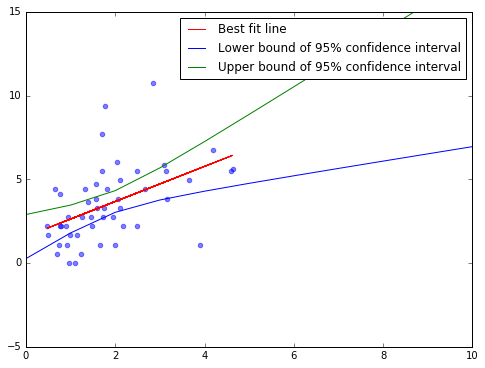

In [26]:
#grab 50 random samples:  # or maybe grab one day?
rand_sample = nsfo_taxi.sample(50)

# create scatter plot extra fare vs time
x,extra = rand_sample.column("dist (miles)"), rand_sample.column("extra")
plt.figure(figsize = (8,6))
plt.scatter(x, extra, color='blue', alpha = .5)

plt.plot(x, fit(x,extra), color='red', label = 'Best fit line')
plt.ylim([-5,15])
plt.xlim([0,10])


l_int, u_int = [],[]
for dist in range(11):
    lower, upper = conf_int(predict_extra(rand_sample,dist), np.std(extra), len(extra), 
                            dist, np.mean(x), np.std(x))
    l_int.append(lower)
    u_int.append(upper)

plt.plot(range(11), l_int, label = 'Lower bound of 95% confidence interval')
plt.plot(range(11), u_int, label = 'Upper bound of 95% confidence interval')

plt.legend()

### Overlaying 20 best fit lines
For any group of 50 randomly selected samples, we will get a new best-fit line. The 95% confidence interval indicates that we expect about 95% of these best-fit lines to fall within these bounds. Let's test this out by selecting 20 random groups of 50 samples and plotting the best-fit line.

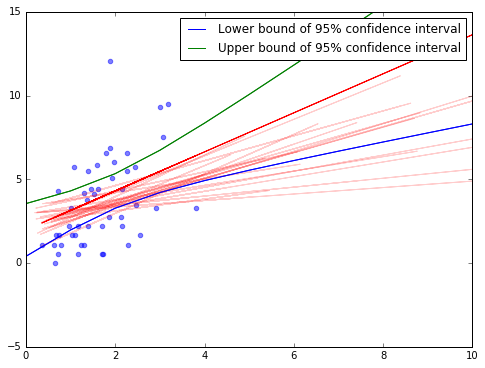

In [25]:
# replot the best fit line and confidence interval from above
plt.figure(figsize = (8,6))
plt.scatter(x, extra, color='blue', alpha = .5)

plt.plot(x, fit(x,extra), color='red')
plt.ylim([-5,15])
plt.xlim([0,10])

plt.plot(range(11), l_int, 'blue', label = 'Lower bound of 95% confidence interval')
plt.plot(range(11), u_int, 'green', label = 'Upper bound of 95% confidence interval')

#add best fit line for 20 more runs
for i in range(20):
    rand_sample = nsfo_taxi.sample(50)

    # create scatter plot extra fars vs time
    x_, extra_ = rand_sample.column("dist (miles)"), rand_sample.column("extra")
    plt.plot(x_, fit(x_,extra_), color='red', alpha=.2)

     
plt.plot(range(11), l_int)
plt.plot(range(11), u_int)
plt.legend()

**Question:** Notice that the confidence intervals have a kind of bow-tie shape, where it's narrower in the middle and wider at the edges. What does this signify? Why do you think this is?

In [14]:
# Your answer here

## Effect of sample size on confidence interval


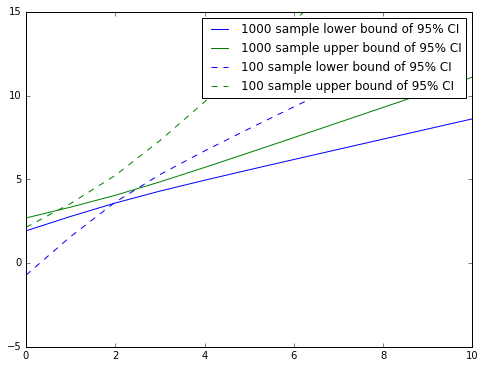

In [15]:
plt.figure(figsize = (8,6))
plt.ylim([-5,15])
plt.xlim([0,10])


#1000 sample confidence interval
rand_sample = nsfo_taxi.sample(1000)
x,extra = rand_sample.column("dist (miles)"), rand_sample.column("extra")
l_int, u_int = [],[]
for dist in range(11):
    lower, upper = conf_int(predict_extra(rand_sample,dist), np.std(extra), len(extra), 
                            dist, np.mean(x), np.std(x))
    l_int.append(lower)
    u_int.append(upper)

plt.plot(range(11), l_int, ls='-', color='blue', label = '1000 sample lower bound of 95% CI')
plt.plot(range(11), u_int, ls='-', color='green', label = '1000 sample upper bound of 95% CI')


#100 sample confidence interval

# Your code here! Make the line style '--' so you can tell which confidence interval is which.



plt.legend()

**Question:** How does the 100 sample confidence interval compare to the 1000 sample confidence interval. Run the above code a few times to see a few iterations, how do the confidence intervals change from run to run?

What does this tell you about the relationship between confidence interval and sample size?

In [16]:
#Answer here:



# Part 4 - switching to bikeshare data
Plotting bike counts vs. temp for Tuesdays at noon and looking at the confidence intervals.

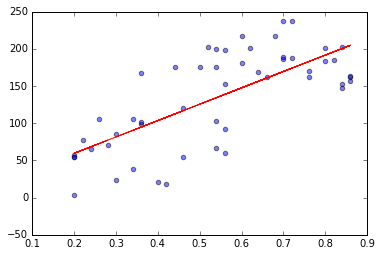

In [17]:
bikeData = Table.read_table('data/bikeshare_2011.csv')
bike_noon = bikeData.where(bikeData['hour'] == 12)
bike_noon_tuesday = bike_noon.where(bike_noon['weekday'] == 2)

# use half the data e.g. to predict for the other half
# bike_noon_tuesday = bike_noon_tuesday.sample(len(bike_noon_tuesday['count'])/2)

plt.scatter(bike_noon_tuesday['temp'], bike_noon_tuesday['count'], alpha=.5)
x,y = bike_noon_tuesday.column('temp'), bike_noon_tuesday.column('count')
plt.plot(x, fit(x,y), color='red')

### Make a predictor method for count given a table and temperature.

In [18]:
def predict_count(table, temp):
    
    # compute parameters of a linear regression for the 'extra', as a function of distance
    a,b = linear_coeff(table, "temp", "count")
    
    #return extra
    return (a*temp + b)

### Add confidence interval to the scatter plot

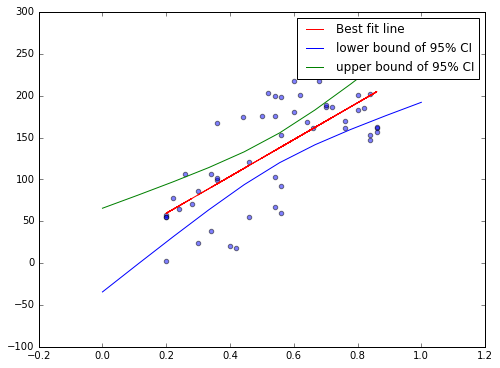

In [29]:
plt.figure(figsize = (8,6))
plt.scatter(bike_noon_tuesday['temp'], bike_noon_tuesday['count'], alpha = .5)
temps,counts = bike_noon_tuesday.column('temp'), bike_noon_tuesday.column('count')
plt.plot(temps, fit(temps,counts), color='red', label = 'Best fit line')

l_int, u_int =[],[]
for t in np.linspace(0,1.0, 10):
    lower, upper = conf_int(predict_count(bike_noon_tuesday,t), np.std(counts), len(counts), 
                            t, np.mean(temps), np.std(temps))
    l_int.append(lower)
    u_int.append(upper)

plt.plot(np.linspace(0,1.0, 10), l_int, ls='-', color='blue', label = 'lower bound of 95% CI')
plt.plot(np.linspace(0,1.0, 10), u_int, ls='-', color='green', label = 'upper bound of 95% CI')

plt.legend()

**Question:** What is the sample size used to generate the best-fit curve above?
What does this confidence interval tell us about the predictive power of the data?

Hint: Adding more inputs to our model is good, but we risk overfitting if we segment our data too much!

In [20]:
# your answer here